# target encoder & ohe & FM

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, fm

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# fillna
for col in test_df.columns:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    test_df[col].fillna(test_df[col].mode()[0], inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

class_col = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
for col in bin_col:
    map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
    train_df[col] = train_df[col].map(map_dict)
    test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col, class_col)
ecd.fit(train_df, verbose=1)

600000it [00:11, 52988.03it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 50999.62it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:12, 48977.80it/s]
400000it [00:08, 49766.02it/s]


# fit one

In [16]:
learning_rate =1e-3
batch_size =  8192
epochs = 100
patience = 2

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': tf.keras.optimizers.Adam(learning_rate=learning_rate),
               'loss': tf.keras.losses.BinaryCrossentropy(),
               'l1_linear':0.,
               'l2_linear': 0.,
               'l1_pair':0.1, 
               'l2_pair':0.1}

callback = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=patience, mode='max')
fit_param = {'batch_size': 8192, 'epochs':epochs, 'verbose': 1, 'callbacks':[callback]}

model = fm(**model_param)

cv = CV(model, 5)

cv.fit(x=[idx, val],
       y=y_train, 
       metrics_func=roc_auc_score,
       split_method=StratifiedKFold,
       fit_params=fit_param,
       eval_param={'batch_size':batch_size},
       use_proba=False, 
       verbose=True,
       fit_use_valid=True)

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 3s 6us/sample - loss: 45.6115 - AUC: 0.5068 - val_loss: 3.5221 - val_AUC: 0.5348
Epoch 2/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.6631 - AUC: 0.5565 - val_loss: 1.1915 - val_AUC: 0.6141
Epoch 3/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.1778 - AUC: 0.6586 - val_loss: 1.1596 - val_AUC: 0.6932
Epoch 4/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.1638 - AUC: 0.7229 - val_loss: 1.1517 - val_AUC: 0.7354
Epoch 5/100
480000/480000 [==============================] - 2s 3us/sample - loss: 1.1511 - AUC: 0.7538 - val_loss: 1.1521 - val_AUC: 0.7552
Epoch 6/100
480000/480000 [==============================] - 2s 3us/sample - loss: 1.1398 - AUC: 0.7686 - val_loss: 1.1452 - val_AUC: 0.7650
Epoch 7/100
480000/480000 [==============================] - 2s 3us/sample - loss: 1.1278 - AUC: 0.77

480000/480000 [==============================] - 2s 4us/sample - loss: 1.6870 - AUC: 0.7932 - val_loss: 1.6637 - val_AUC: 0.7839
Epoch 8/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.6091 - AUC: 0.7939 - val_loss: 1.5410 - val_AUC: 0.7843
Epoch 9/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.5452 - AUC: 0.7944 - val_loss: 1.5111 - val_AUC: 0.7846
Epoch 10/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.4940 - AUC: 0.7948 - val_loss: 1.5065 - val_AUC: 0.7847
Epoch 11/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.4502 - AUC: 0.7953 - val_loss: 1.4557 - val_AUC: 0.7849
Epoch 12/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.4123 - AUC: 0.7956 - val_loss: 1.4425 - val_AUC: 0.7850
Epoch 13/100
480000/480000 [==============================] - 2s 4us/sample - loss: 1.3800 - AUC: 0.7958 - val_loss: 1.3648 - val_AUC: 0.7850
Epoch 14/100
480000/4

0.7847274841252525

In [18]:
model_lst = cv.model
model_lst[0].get_weights()

[array([[ 8.68425705e-05,  1.25098130e-04,  7.61014744e-05, ...,
          9.10201124e-05, -1.59656542e-04, -6.46640401e-05],
        [-5.85156740e-05,  1.71531108e-04, -1.08824315e-04, ...,
         -4.87733923e-05, -1.64253106e-05, -2.03166943e-04],
        [-1.33402224e-04, -5.59204054e-05,  1.80689502e-04, ...,
          1.30275526e-04,  9.61374972e-05, -5.60243061e-05],
        ...,
        [-4.48581413e-05,  2.59245804e-04,  3.10742325e-05, ...,
          1.28844476e-04,  2.72234087e-04, -3.86328866e-05],
        [-4.81687384e-05, -1.95962450e-04, -9.99568874e-06, ...,
         -1.21068224e-05, -4.66797865e-05,  1.37649200e-04],
        [-2.49055040e-04,  2.49408477e-04, -2.40813155e-04, ...,
          2.54910119e-05, -6.70916997e-05,  1.31026318e-04]], dtype=float32),
 array([[-0.21192501],
        [ 0.17532426],
        [-0.26370415],
        ...,
        [-0.19879094],
        [ 0.03098572],
        [-0.04212531]], dtype=float32)]

# Tuning

In [10]:
# fit param
callback = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=2, mode='max')
fit_param = {'batch_size': 8192, 'epochs':100, 'verbose': 0, 'callbacks':[callback]}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':8192},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': opt, 
                   'k': 10}

model_search_space = {'loss': hp.choice('loss', ['MSE', tf.keras.losses.BinaryCrossentropy()]),
                      'l1_pair': hp.loguniform('l1', -20, 0),
                      'l2_pair': hp.loguniform('l2', -20, 0)}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=5, 
                random_state=2333,
                model=fm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=model_search_space)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7834, param {'l1_pair': 2.1383198575114704e-05, 'l2_pair': 0.0001182810995421841, 'loss': 'MSE'}
new best, eval 2, score -0.7839, param {'l1_pair': 0.010410431935348215, 'l2_pair': 0.6275871054712372, 'loss': 'MSE'}
new best, eval 3, score -0.7839, param {'l1_pair': 5.286715429147466e-07, 'l2_pair': 0.10579294525493872, 'loss': 'MSE'}
new best, eval 7, score -0.7839, param {'l1_pair': 0.02304106494804331, 'l2_pair': 7.0123606439973846e-09, 'loss': 'MSE'}
new best, eval 10, score -0.7848, param {'l1_pair': 0.0015827326602032652, 'l2_pair': 0.04932812485248445, 'loss': <tensorflow.python.keras.losses.BinaryCrossentropy object at 0x7f8128cd5fd0>}
new best, eval 21, score -0.7848, param {'l1_pair': 0.7797287497562283, 'l2_pair': 0.001122653710865107, 'loss': <tensorflow.python.keras.losses.BinaryCrossentropy object at 0x7f8128cd5fd0>}
new best, eval 24, score -0.7848, param {'l1_pair': 0.17657790128622586, 'l2_pair': 0.0010659965034824086, 'loss': <tensorflow.pyt

{'l1': 0.17806231899592775, 'l2': 0.010142810617512113, 'loss': 1}

In [ ]:
{'l1': 0.17806231899592775, 'l2': 0.010142810617512113, 'loss': 1}

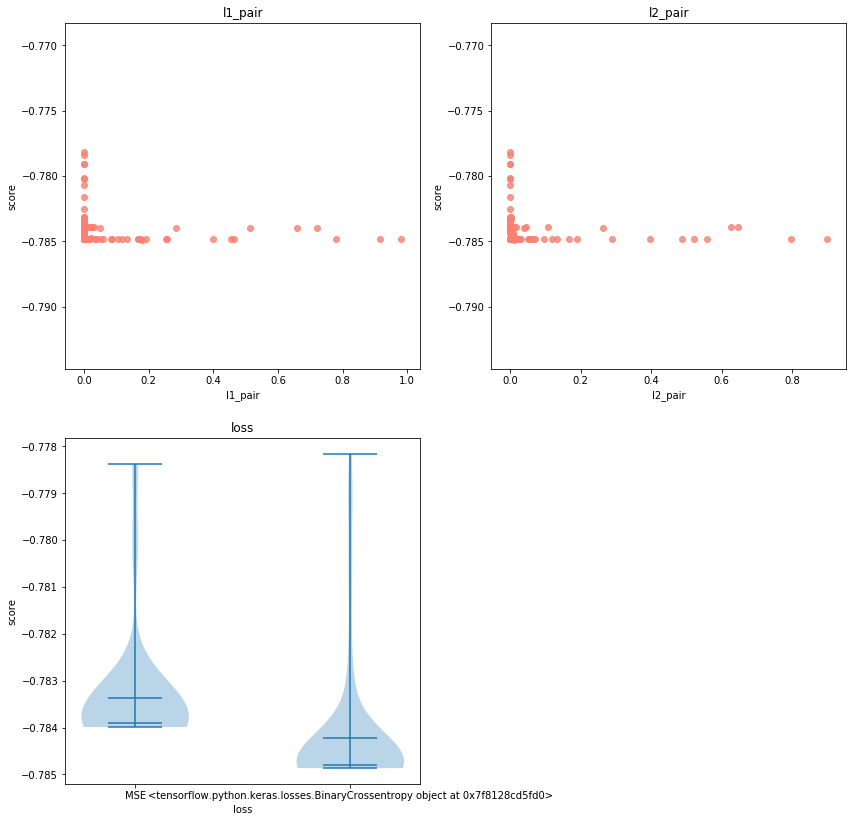

In [11]:
tuning.log.plot()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model = linear_regression(vocabulary_size=ecd.get_vocabulary(), 
                          feature_number=len(feature_col),, 
                          activation='sigmoid',
                          loss='mse',
                          metrics=['AUC'],
                          optimizer=opt, 
                          l1=0., l2=0.)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5, mode='max')
fit_param = {'batch_size':1024, 'epochs':20, 'verbose': 1, 'callbacks':[callback]}

In [ ]:
pred_param = {'batch_size':1024}

cv = CV(model, 5)

cv.fit(x=[idx, val],
       y=y_train, 
       metrics_func=roc_auc_score,
       split_method=StratifiedKFold,
       fit_params=fit_param,
       eval_param=pred_param,
       use_proba=False, 
       verbose=True,
       fit_use_valid=True)

In [ ]:
np.exp(-10)